In [1]:
import pandas as pd
import numpy as np
from transformers import T5Tokenizer, T5EncoderModel, EsmTokenizer, EsmModel, EsmForSequenceClassification
import json
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_recall_curve, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./Datasets/My_Dataset/proteins_df_annotated.csv', index_col=0)
uniprot_id = list(df.uniprot_id.unique())
df

,uniprot_id,residue_1l,residue_3l,residue_index,is_IBS,sequence
id,,,,,,
0,P14555,M,MET,1,0,MKTLLLLAVIMIFGLLQAHGNLVNFHRMIKLTTGKEAALSYGFYGC...
1,P14555,K,LYS,2,0,MKTLLLLAVIMIFGLLQAHGNLVNFHRMIKLTTGKEAALSYGFYGC...
2,P14555,T,THR,3,0,MKTLLLLAVIMIFGLLQAHGNLVNFHRMIKLTTGKEAALSYGFYGC...
3,P14555,L,LEU,4,0,MKTLLLLAVIMIFGLLQAHGNLVNFHRMIKLTTGKEAALSYGFYGC...
4,P14555,L,LEU,5,0,MKTLLLLAVIMIFGLLQAHGNLVNFHRMIKLTTGKEAALSYGFYGC...
...,...,...,...,...,...,...
325938,P01441,T,THR,56,0,LKCKKLVPLFSKTCPAGKNLCYKMFMVAAPHVPVKRGCIDVCPKSS...
325939,P01441,D,ASP,57,0,LKCKKLVPLFSKTCPAGKNLCYKMFMVAAPHVPVKRGCIDVCPKSS...
325940,P01441,K,LYS,58,0,LKCKKLVPLFSKTCPAGKNLCYKMFMVAAPHVPVKRGCIDVCPKSS...


### protTrans model - prot_t5_xl_half_uniref50-enc

In [3]:
## set some constants
max_residues = 4000
max_seq_len = 1000
max_batch = 100

In [5]:
############### load model ###############

# For feature extraction we recommend to use the encoder embedding
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50) 
tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16)
# Currently (06/2022) half-precision models cannot be used on CPU. If you want to use the encoder only version on CPU, you need to cast it to its full-precision version (model=model.float())
model=model.float()

#### Extract Embeddings

In [ ]:
# repl. all non-standard AAs and map them to unknown/X
proteins_with_seq = df[['uniprot_id', 'sequence']].groupby('uniprot_id').apply(lambda x: list(np.unique(x['sequence']))[0].replace('U','X').replace('Z','X').replace('O','X')).to_dict()

# sort sequences according to length (reduces unnecessary padding --> speeds up embedding)
seq_dict = sorted( proteins_with_seq.items(), key=lambda kv: len( proteins_with_seq[kv[0]] ), reverse=True )
batch = list()
results = dict()

for seq_idx, (pdb_id, seq) in tqdm(enumerate(seq_dict,1)):
  seq = seq
  seq_len = len(seq)
  seq = ' '.join(list(seq)) # add space between each AA
  batch.append((pdb_id,seq,seq_len))

  # count residues in current batch and add the last sequence length to
  # avoid that batches with (n_res_batch > max_residues) get processed 
  n_res_batch = sum([ s_len for  _, _, s_len in batch ]) + seq_len 

  if len(batch) >= max_batch or n_res_batch>=max_residues or seq_idx==len(seq_dict) or seq_len>max_seq_len:
    pdb_ids, seqs, seq_lens = zip(*batch)
    batch = list()

    # add_special_tokens adds extra token at the end of each sequence
    token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
    input_ids      = torch.tensor(token_encoding['input_ids'])
    attention_mask = torch.tensor(token_encoding['attention_mask'])

    try:
      with torch.no_grad():
        # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
        embedding_repr = model(input_ids, attention_mask=attention_mask)
    except RuntimeError:
      print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
      continue

    for batch_idx, identifier in enumerate(pdb_ids): # for each protein in the current mini-batch
      s_len = seq_lens[batch_idx]

      # slice off padding --> batch-size x seq_len x embedding_dim  
      emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
      # store per-residue embeddings (Lx1024)
      results[identifier] = emb.detach().cpu().numpy().squeeze()
  break

In [ ]:
# save to json file
json_object = json.dumps({k: v.tolist() for k, v in results.items()}, indent=2)

# Writing to sample.json
with open("embeddings.json", "w") as outfile:
    outfile.write(json_object)

In [2]:
f = open('./Datasets/My_Dataset/embeddings.json')
dict_embeddings = json.load(f)
f.close()

### ESM model - esm2_t33_650M_UR50D

In [4]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D", do_lower_case=False)

model = EsmModel.from_pretrained("facebook/esm2_t33_650M_UR50D")

Some weights of the model checkpoint at facebook/esm2_t33_650M_UR50D were not used when initializing EsmModel: ['lm_head.dense.bias', 'esm.contact_head.regression.weight', 'esm.contact_head.regression.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this mode

#### Extract Embeddings

In [ ]:
# repl. all non-standard AAs and map them to unknown/X
proteins_with_seq = df[['uniprot_id', 'sequence']].groupby('uniprot_id').apply(lambda x: list(np.unique(x['sequence']))[0].replace('U','X').replace('Z','X').replace('O','X')).to_dict()

# sort sequences according to length (reduces unnecessary padding --> speeds up embedding)
seq_dict = sorted( proteins_with_seq.items(), key=lambda kv: len( proteins_with_seq[kv[0]] ), reverse=True )
results = dict()

for seq_idx, (pdb_id, seq) in tqdm(enumerate(seq_dict,1)):
  seq = seq
  seq_len = len(seq)
  
  # add_special_tokens adds extra token at the end of each sequence
  token_encoding = tokenizer(seq, return_tensors="pt")

  try:
    with torch.no_grad():
      # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
      embedding_repr = model(**token_encoding)
  except RuntimeError:
    print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
    continue
  
  emb = embedding_repr.last_hidden_state[:,:seq_len]
  # # store per-residue embeddings (Lx1024)
  results[pdb_id] = emb.detach().cpu().numpy().squeeze()

In [6]:
# save to json file
json_object = json.dumps({k: v.tolist() for k, v in results.items()}, indent=2)

# Writing to sample.json
with open("embeddings_esm.json", "w") as outfile:
    outfile.write(json_object)

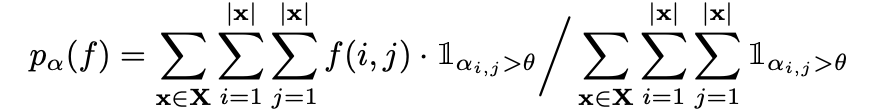